# Import Module

In [95]:
import os, sys, random
from glob import glob
from tqdm.notebook import tqdm

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix, accuracy_score

from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input

# Load Data

In [13]:
%%shell

# Download dataset
wget -qnc https://lazyprogrammer.me/course_files/Food-5K.zip
unzip -qn Food-5K.zip
mv -n Food-5K/* .


# split image by food vs non-food
mkdir -p data/train/nonfood
mkdir -p data/train/food
mkdir -p data/test/nonfood
mkdir -p data/test/food

mv training/0*.jpg data/train/nonfood
mv training/1*.jpg data/train/food
mv validation/0*.jpg data/test/nonfood
mv validation/1*.jpg data/test/food

evaluation  Food-5K  Food-5K.zip  __MACOSX  sample_data  training  validation


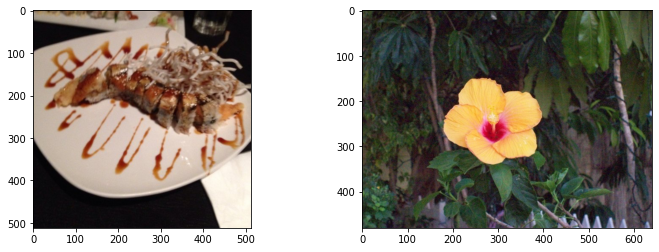

In [47]:
fig, axes = plt.subplots(1,2, figsize=(12, 4))

img = glob('data/train/food/*')[42]
axes[0].imshow(image.load_img(img))

img = glob('data/train/nonfood/*')[42]
axes[1].imshow(image.load_img(img))

plt.show();

# Modeling

In [2]:
IMAGE_SIZE = [200, 200]
K = len(glob('data/train' + '/*')) # number of classes

ptm = PretrainedModel(input_shape=IMAGE_SIZE + [3],     # [3] is RGB
                      weights='imagenet', 
                      include_top=False)                # info not needed
ptm.trainable = False   # not retraining the model

## Without Data Augmentation
- only traning logistic regression for image classification
- quick but possibly worse generalization

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [3]:
x = Flatten()(ptm.output)
model = Model(inputs=ptm.input, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [4]:
gen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size = 128

# create generators
train_generator = gen.flow_from_directory(
                        'data/train/',
                        target_size=IMAGE_SIZE,
                        batch_size=batch_size,
                        class_mode='binary',)

valid_generator = gen.flow_from_directory(
                        'data/test/',
                        target_size=IMAGE_SIZE,
                        batch_size=batch_size,
                        class_mode='binary',)   

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
def vgg_output_gen(generator, model, N, X_set, y_set):
    i = 0
    for x, y in valid_generator:
        # get features
        features = model.predict(x)
        
        # size of the batch (may not always be batch_size)
        sz = len(y)
        
        # assign to X_train and Ytrain
        X_set[i:i + sz] = features
        y_set[i:i + sz] = y
        
        # increment i
        i += sz
        print(i)

        if i >= N:
            print('DONE')
            break

    return (X_set, y_set)

In [12]:
# Store output result from pretrained + flatten layer

N_train = len(glob('data/train' + '/*/*.jpg'))
N_val = len(glob('data/test' + '/*/*.jpg'))

# Output size = Flatten
D = model.predict(np.random.random([1] + IMAGE_SIZE + [3])).shape[1]

X_train = np.zeros((N_train, D))
y_train = np.zeros(N_train) 
X_val = np.zeros((N_val, D))    
y_val = np.zeros(N_val)

# make prediction & store in matrices
X_train, y_train = vgg_output_gen(train_generator, model, N_train, X_train, y_train)
X_val, y_val = vgg_output_gen(valid_generator, model, N_val, X_val, y_val)

128
256
384
512
640
768
896
1000
1128
1256
1384
1512
1640
1768
1896
2000
2128
2256
2384
2512
2640
2768
2896
3000
DONE
128
256
384
512
640
768
896
1000
DONE


In [17]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

### LogRegr w/ Sklearn

In [18]:
logr = LogisticRegression()
logr.fit(X_train, y_train)
print(logr.score(X_train, y_train))
print(logr.score(X_val, y_val))

1.0
1.0


### LogRegr w/ TF


In [22]:
i = Input(shape=(D,))
x = Dense(1, activation='sigmoid')(i)
linearmodel = Model(i, x)


es = EarlyStopping(monitor='val_accuracy', 
                    patience=8, 
                    min_delta=0.001, 
                    mode='max')

linearmodel.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

r = linearmodel.fit(
    X_train, y_train,
    batch_size=128,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[es]
)

Epoch 1/10
24/24 [==============================] - 1s 13ms/step - loss: 0.0954 - accuracy: 0.9547 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 2/10
24/24 [==============================] - 0s 9ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 6.2929e-04 - val_accuracy: 1.0000
Epoch 3/10
24/24 [==============================] - 0s 9ms/step - loss: 5.4642e-04 - accuracy: 1.0000 - val_loss: 4.5601e-04 - val_accuracy: 1.0000
Epoch 4/10
24/24 [==============================] - 0s 9ms/step - loss: 4.2255e-04 - accuracy: 1.0000 - val_loss: 3.8006e-04 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 0s 9ms/step - loss: 3.5628e-04 - accuracy: 1.0000 - val_loss: 3.2507e-04 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 0s 8ms/step - loss: 3.0648e-04 - accuracy: 1.0000 - val_loss: 2.8296e-04 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 0s 8ms/step - loss: 2.6961e-04 - accuracy: 1.0000 - val_loss: 2.4904e-0

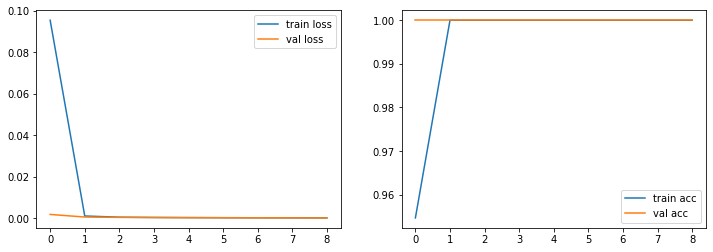

In [23]:
fig, axes = plt.subplots(1,2,figsize=(12,4))

axes[0].plot(r.history['loss'], label='train loss')
axes[0].plot(r.history['val_loss'], label='val loss')
axes[0].legend()

axes[1].plot(r.history['accuracy'], label='train acc')
axes[1].plot(r.history['val_accuracy'], label='val acc')
axes[1].legend()
    
plt.show();

## With Data Augmentation
- compute entire CNN with augmented dataset
- slow but possibly better generalization

In [31]:
x = Flatten()(ptm.output)
x = Dense(K, activation='softmax')(x)

model = Model(inputs=ptm.input, outputs=x)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0   

In [32]:
# Generate augmented image ONLY to train set to increase training sample size
gen_train = image.ImageDataGenerator(rotation_range=20,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                preprocessing_function=preprocess_input)
# test set won't be augmented
gen_test = image.ImageDataGenerator(preprocessing_function=preprocess_input)    



batch_size = 128
train_generator = gen_train.flow_from_directory(
                                'data/train/',
                                shuffle=True,
                                target_size=IMAGE_SIZE,
                                batch_size=batch_size,)
valid_generator = gen_test.flow_from_directory(
                                'data/test/',
                                target_size=IMAGE_SIZE,
                                batch_size=batch_size,)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [33]:
es = EarlyStopping(monitor='val_accuracy', 
                    patience=8, 
                    min_delta=0.001, 
                    mode='max')


model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

r = model.fit(train_generator,
                validation_data=valid_generator,
                epochs=20,
                steps_per_epoch=int(np.ceil(len(glob('data/train' + '/*/*.jpg')) / batch_size)),
                validation_steps=int(np.ceil(len(glob('data/test' + '/*/*.jpg')) / batch_size)),
                callbacks=[es])

Epoch 1/20
24/24 [==============================] - 82s 3s/step - loss: 2.1814 - accuracy: 0.9047 - val_loss: 0.4654 - val_accuracy: 0.9780
Epoch 2/20
24/24 [==============================] - 43s 2s/step - loss: 0.7858 - accuracy: 0.9713 - val_loss: 0.5103 - val_accuracy: 0.9770
Epoch 3/20
24/24 [==============================] - 43s 2s/step - loss: 0.5214 - accuracy: 0.9783 - val_loss: 0.5785 - val_accuracy: 0.9750
Epoch 4/20
24/24 [==============================] - 43s 2s/step - loss: 0.2701 - accuracy: 0.9853 - val_loss: 0.7157 - val_accuracy: 0.9750
Epoch 5/20
24/24 [==============================] - 43s 2s/step - loss: 0.2033 - accuracy: 0.9863 - val_loss: 0.6947 - val_accuracy: 0.9730
Epoch 6/20
24/24 [==============================] - 43s 2s/step - loss: 0.1179 - accuracy: 0.9910 - val_loss: 0.7794 - val_accuracy: 0.9750
Epoch 7/20
24/24 [==============================] - 43s 2s/step - loss: 0.2018 - accuracy: 0.9893 - val_loss: 0.7046 - val_accuracy: 0.9760
Epoch 8/20
24/24 [==

In [34]:
# create train generator without data augmentation to get the true train accuracy
train_generator2 = gen_test.flow_from_directory(
  'data/train/',
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)
model.evaluate(
    train_generator2,
    steps=int(np.ceil(len(glob('data/train' + '/*/*.jpg')) / batch_size)))

Found 3000 images belonging to 2 classes.
24/24 [==============================] - 19s 777ms/step - loss: 0.0194 - accuracy: 0.9980


[0.019421188160777092, 0.9980000257492065]

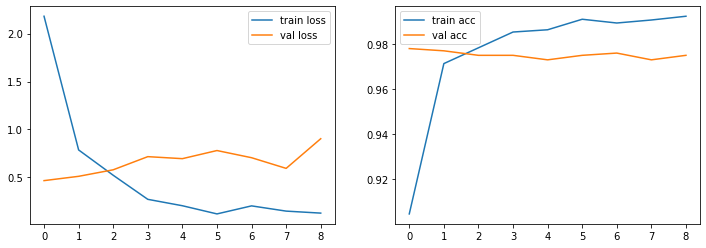

In [35]:
fig, axes = plt.subplots(1,2,figsize=(12,4))

axes[0].plot(r.history['loss'], label='train loss')
axes[0].plot(r.history['val_loss'], label='val loss')
axes[0].legend()

axes[1].plot(r.history['accuracy'], label='train acc')
axes[1].plot(r.history['val_accuracy'], label='val acc')
axes[1].legend()
    
plt.show();

[[0. 1.]]


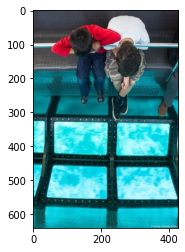

[[1. 0.]]


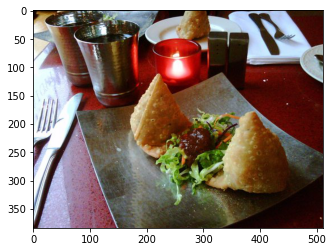

In [80]:
# Sample prediction

img = random.choice(glob('data/train/nonfood/*'))
im = cv2.resize(cv2.imread(img), tuple(IMAGE_SIZE)).astype(np.float32)
# im = im.transpose((2,0,1))
im = np.expand_dims(im, axis=0)
print(model.predict(im))
plt.imshow(image.load_img(img));
plt.show();

img = random.choice(glob('data/train/food/*'))
im = cv2.resize(cv2.imread(img), tuple(IMAGE_SIZE)).astype(np.float32)
# im = im.transpose((2,0,1))
im = np.expand_dims(im, axis=0)
print(model.predict(im))
plt.imshow(image.load_img(img));
plt.show();

In [90]:
y_test = []
k = 0
for c in glob('data/test/*'):    
    for i in glob(c + '/*'):
        y_test.append(k)
    k += 1

In [92]:
y_pred = []
for i in tqdm(glob('data/test' + '/*/*.jpg')):
    im = cv2.resize(cv2.imread(i), tuple(IMAGE_SIZE)).astype(np.float32)
    im = np.expand_dims(im, axis=0)
    y_pred.append(model.predict(im).argmax())

In [108]:
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.975
[[488  12]
 [ 13 487]]


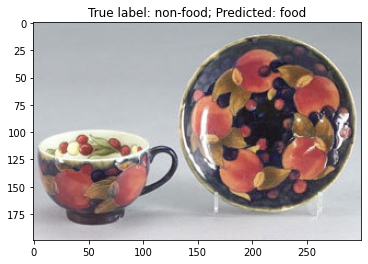

In [116]:
y_pred = np.array(y_pred)
y_test = np.array(y_test)

labels = ['food','non-food']
misclassified_idx = np.where(y_pred != y_test)[0]

i = np.random.choice(misclassified_idx)
plt.imshow(image.load_img(glob('data/test' + '/*/*.jpg')[i]));
plt.title("True label: %s; Predicted: %s" % (labels[y_test[i]], labels[y_pred[i]]));